In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_style('darkgrid')
# import cv2
import itertools

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
import imageio
import matplotlib.image as img

import os 
import pathlib 

import warnings
warnings.filterwarnings('ignore')

In [28]:
path = pathlib.Path(r"/kaggle/input/the-kvasir-dataset/kvasir-dataset-v2")

In [29]:
dyed_ifted_polyps = list(path.glob('dyed-lifted-polyps/*'))
dyed_resection_margins = list(path.glob('dyed-resection-margins/*'))
esophagitis = list(path.glob('esophagitis/*'))
normal_cecum = list(path.glob('normal-cecum/*'))
normal_pylorus = list(path.glob('normal-pylorus/*'))
normal_z_line = list(path.glob('normal-z-line/*'))
polyps = list(path.glob('polyps/*'))
ulcerative_colitis = list(path.glob('ulcerative-colitis/*'))

In [30]:
data = {
    'dyed-lifted-polyps' : dyed_ifted_polyps ,
    'dyed-resection-margins' : dyed_resection_margins,
    'esophagitis' : esophagitis,
    'normal-cecum' : normal_cecum,
    'normal-pylorus' : normal_pylorus,
    'normal-z-line' : normal_z_line,
    'polyps' : polyps,
    'ulcerative-colitis' : ulcerative_colitis
}

polys_labels = {
    0:'dyed-lifted-polyps',
    1:'dyed-resection-margins',
    2:'esophagitis',
    3:'normal-cecum',
    4:'normal-pylorus',
    5:'normal-z-line',
    6:'polyps',
    7:'ulcerative-colitis'
}

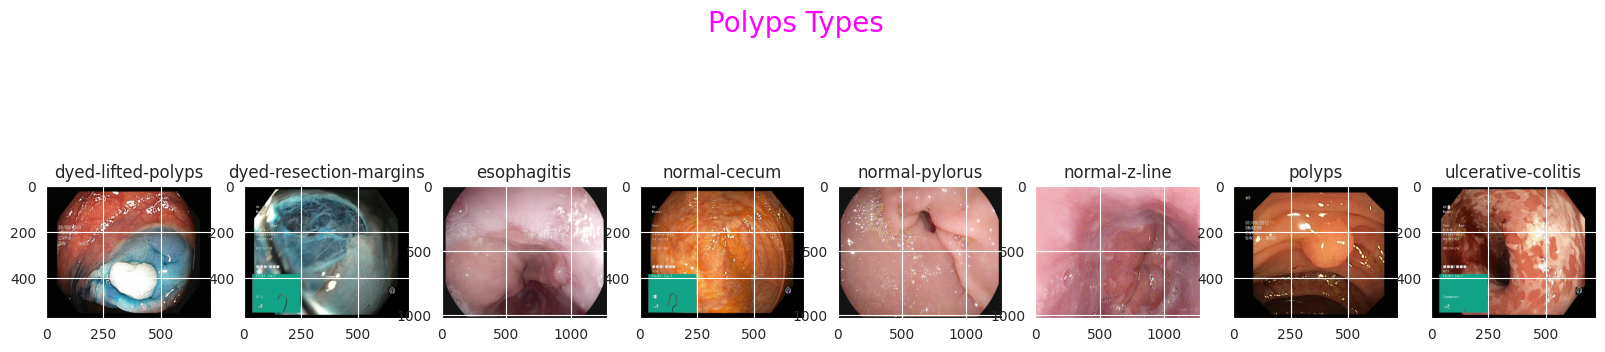

In [31]:
fig , ax = plt.subplots(ncols=8 , figsize=(20,5))

fig.suptitle ('Polyps Types', color='magenta', fontsize = 20)

dyed_ifted_polyps_img = img.imread(dyed_ifted_polyps[0])

dyed_resection_margins_img = img.imread(dyed_resection_margins[0])

esophagitis_img = img.imread(esophagitis[0])

normal_cecum_img = img.imread(normal_cecum[0])

normal_pylorus_img = img.imread(normal_pylorus[0])

normal_z_line_img = img.imread(normal_z_line[0])

polyps_img = img.imread(polyps[0])

ulcerative_colitis_img = img.imread(ulcerative_colitis[0])

ulcerative_colitis_img = img.imread(ulcerative_colitis[0])
for index,name in enumerate(list(data.keys())):
    
    ax[index].set_title(name)
    
ax[0].imshow(dyed_ifted_polyps_img)

ax[1].imshow(dyed_resection_margins_img)

ax[2].imshow(esophagitis_img)

ax[3].imshow(normal_cecum_img)

ax[4].imshow(normal_pylorus_img)

ax[5].imshow(normal_z_line_img)

ax[6].imshow(polyps_img)

ax[7].imshow(ulcerative_colitis_img)


In [32]:
batch_size = 32
transform = transforms.Compose(
    [transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])])

dataset = torchvision.datasets.ImageFolder(root='/kaggle/input/the-kvasir-dataset/kvasir-dataset-v2', transform=transform)
train_set, val_set = torch.utils.data.random_split(dataset, [6400, 1600])
trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(val_set, batch_size=batch_size,
                                          shuffle=False, num_workers=4)

In [33]:
class PatchEmbed(nn.Module):
    def __init__(self, img_size, patch_size, in_chans=3, embed_dim = 768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size//patch_size)**2
        
        self.proj = nn.Conv2d(
            in_chans,
            embed_dim,
            kernel_size = patch_size,
            stride = patch_size,
        )
        
    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2)
        x = x.transpose(1,2)
        
        return x

In [34]:
class Attention(nn.Module):
    def __init__(self, dim, n_heads=12, qkv_bias=True, attn_p=0., proj_p=0.):
        super().__init__()
        self.n_heads = n_heads
        self.dim = dim
        self.head_dim = dim // n_heads
        self.scale = self.head_dim ** -0.5
        
        self.qkv = nn.Linear(dim, dim*3, bias = qkv_bias)
        self.attn_drop = nn.Dropout(attn_p)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_p)
    
    def forward(self, x):
        n_samples, n_tokens, dim = x.shape
        if dim != self.dim:
            raise ValueError
        qkv = self.qkv(x)
        qkv = qkv.reshape(n_samples, n_tokens, 3, self.n_heads, self.head_dim)
        qkv = qkv.permute(2,0,3,1,4)
        
        q, k, v = qkv[0], qkv[1], qkv[2]
        k_t = k.transpose(-2, -1)
        dp = (
            q @ k_t
        ) * self.scale
        attn = dp.softmax(dim = -1)
        attn = self.attn_drop(attn)
        
        weighted_avg = attn @ v
        weighted_avg = weighted_avg.transpose(
            1, 2
        )
        weighted_avg = weighted_avg.flatten(2)
        x = self.proj(weighted_avg)
        x = self.proj_drop(x)
        
        return x

In [35]:
class MLP(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, p=0.):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(p)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        
        return x

In [36]:
class Block(nn.Module):
    def __init__(self, dim, n_heads, mlp_ratio = 4.0, qkv_bias = True, p = 0., attn_p = 0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim, eps=1e-6)
        self.attn = Attention(
            dim,
            n_heads=n_heads,
            qkv_bias = qkv_bias,
            attn_p = attn_p,
            proj_p=p
        )
        self.norm2 = nn.LayerNorm(dim, eps=1e-6)
        hidden_features = int(dim * mlp_ratio)
        self.mlp = MLP(
            in_features = dim,
            hidden_features=hidden_features,
            out_features=dim,
        )
    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        
        return x

In [37]:
class VisionTransformer(nn.Module):
    def __init__(
        self,
        img_size = 256,
        patch_size = 16,
        in_chans = 3,
        n_classes = 8,
        embed_dim = 768,
        depth = 8,
        n_heads = 12,
        mlp_ratio = 4.,
        qkv_bias = True,
        p = 0.,
        attn_p = 0.,
    ):
        super().__init__()
        
        self.patch_embed = PatchEmbed(
            img_size = img_size,
            patch_size = patch_size,
            in_chans = in_chans,
            embed_dim = embed_dim,
        )
        
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(
            torch.zeros(1, 1 + self.patch_embed.n_patches, embed_dim)
        )
        self.pos_drop = nn.Dropout(p=p)
        self.blocks = nn.ModuleList(
            [
                Block(
                    dim = embed_dim,
                    n_heads = n_heads,
                    mlp_ratio = mlp_ratio,
                    qkv_bias = qkv_bias,
                    p = p,
                    attn_p = attn_p,
                )
                
                for _ in range(depth)
            ]
        )
        
        self.norm = nn.LayerNorm(embed_dim, eps = 1e-6)
        self.head = nn.Linear(embed_dim, n_classes)
        
    def forward(self, x):
        n_samples = x.shape[0]
        x = self.patch_embed(x)
        
        cls_token = self.cls_token.expand(
            n_samples, -1, -1
        )
        x = torch.cat((cls_token, x), dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)
        
        for block in self.blocks:
            x = block(x)
        
        x = self.norm(x)
        
        cls_token_final = x[:, 0]
        x = self.head(cls_token_final)
        
        return x

In [38]:
model = VisionTransformer()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(model)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-7): 8 x Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (head): Linear(in_features=768, out_features=8, bias=Tr

In [39]:
from torch.optim.lr_scheduler import StepLR

model = model.to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

n_total_steps = len(trainloader)
best_val_acc = 0
patience = 5
no_improve = 0

train_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(10):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for i, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / n_total_steps
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    print(f'Epoch [{epoch+1}/10], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    
    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_acc = 100 * correct / total
    val_accuracies.append(val_acc)
    print(f'Validation Acc: {val_acc:.2f}%')
    
    scheduler.step()

print('Finished Training')

Epoch [1/10], Train Loss: 1.8625, Train Acc: 28.30%
Validation Acc: 52.31%
Epoch [2/10], Train Loss: 0.9521, Train Acc: 53.97%
Validation Acc: 55.50%
Epoch [3/10], Train Loss: 0.9340, Train Acc: 54.80%
Validation Acc: 51.81%
Epoch [4/10], Train Loss: 0.8949, Train Acc: 57.31%
Validation Acc: 54.50%
Epoch [5/10], Train Loss: 0.9181, Train Acc: 55.94%
Validation Acc: 57.06%
Epoch [6/10], Train Loss: 0.9592, Train Acc: 54.70%
Validation Acc: 57.00%
Epoch [7/10], Train Loss: 1.0028, Train Acc: 52.92%
Validation Acc: 51.56%
Epoch [8/10], Train Loss: 0.8536, Train Acc: 58.03%
Validation Acc: 60.00%
Epoch [9/10], Train Loss: 0.8196, Train Acc: 60.66%
Validation Acc: 59.88%
Epoch [10/10], Train Loss: 0.8069, Train Acc: 61.62%
Validation Acc: 58.62%
Finished Training


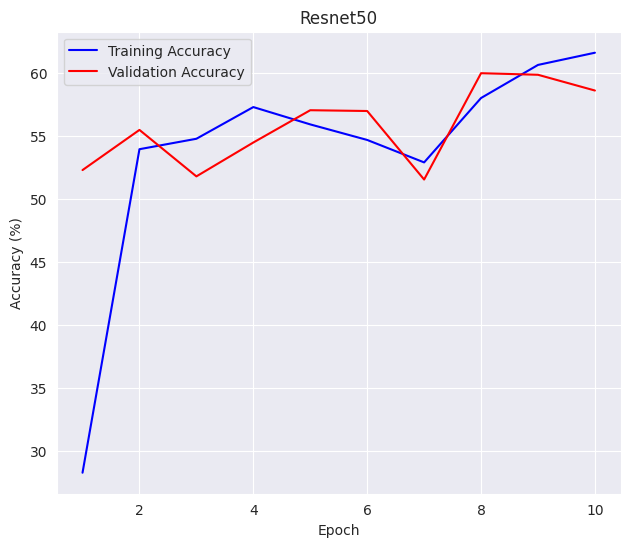

In [40]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, 11), train_accuracies, 'b-', label='Training Accuracy')
plt.plot(range(1, 11), val_accuracies, 'r-', label='Validation Accuracy')
plt.title('Resnet50')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)